<b><font color='darkred'>
Verwenden statistischer Größen der Zeitreihen als Features<br><br>
XGB - XGBoost 
-----------------
- Power[W] &nbsp;&emsp;&emsp; ➔  Generatorleistung, Energie &emsp;➔ p
- Force[N] &emsp;&emsp;&emsp;➔  Pressenkraft &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➔ f
- Distance[mm] &nbsp;➔  Sonotrodenvorschub &emsp;&emsp;&emsp;&emsp;➔ d



In [3]:
import numpy as np
from scipy.stats import uniform, randint
from sklearn import preprocessing, model_selection, ensemble
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
pca = False           # PCA Anwendung ja oder nein?
n_components = 0.98

SCALE = 2000    # Skalierung für Zielvariable Zugfestigkeit


STATS = [
    # Power (p_*)
    "p_mean", "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_iqr", "p_f_ratio", "p_d_ratio", "p_t_ratio",
    
    # Force (f_*)
    #"f_mean", "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_iqr", "f_d_ratio", "f_t_ratio",
    
    # Distance (d_*)
    "d_mean", "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_iqr", "d_t_ratio", "d_b75",
    
    # Zeitmerkmale
    "t_max",
]

# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [5]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [6]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [7]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [8]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

<b><font color='lightgreen'> Skalieren Trainings- und Testdaten mit PCA

In [9]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

In [10]:
if pca == True:
    pca_scaler = PCA(n_components=0.95)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    print(pca_scaler.n_components_, pca_scaler.explained_variance_ratio_)

<b><font color='lightgreen'> Kontrollanzeige t-SNE

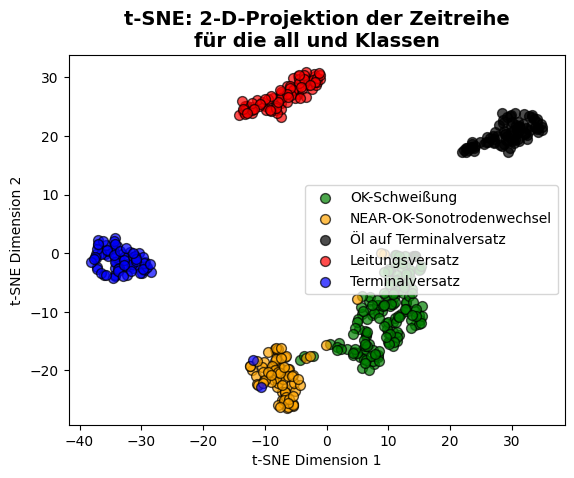

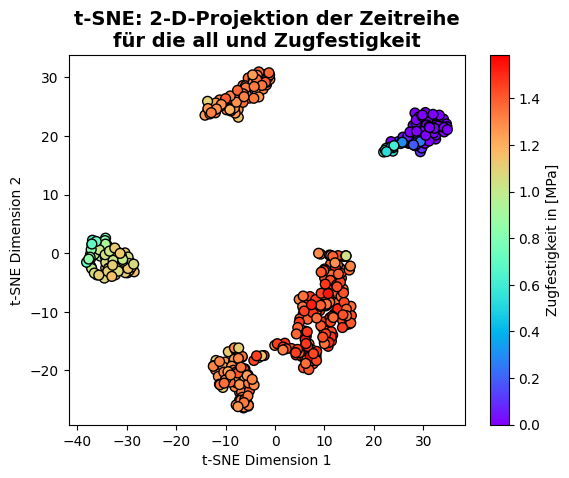

In [11]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> XGBoost für Klassifikation (Hyperparametersuche - Random Search)

In [12]:
# Hyperparameter-Suchraum definieren
param_dist = {
    'n_estimators': randint(50, 300),         # Anzahl der Bäume (50 bis 300)
    'max_depth': randint(3, 10),              # Baumtiefe (3 bis 10)
    'learning_rate': uniform(0.01, 0.3),      # Lernrate (0.01 bis 0.3)
    'subsample': uniform(0.6, 0.4),           # Anteil der Daten pro Baum (0.6 bis 1.0)
    'colsample_bytree': uniform(0.6, 0.4),    # Anteil der Features pro Baum (0.6 bis 1.0)
    'gamma': uniform(0, 0.5),                 # Reduziert Overfitting (0 bis 0.5)
}

# XGBoost-Klassifikationsmodell erstellen
clf = xgb.XGBClassifier(objective="multi:softmax", num_class=5, random_state=42)

# RandomizedSearchCV für Hyperparameter-Tuning
random_search = model_selection.RandomizedSearchCV(
    clf, param_distributions=param_dist, 
    n_iter=100,  
    cv=3, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Training mit der besten Hyperparameter-Kombination
random_search.fit(X_train_scaled, label_train)

# Bestes Modell ausgeben
best_model = random_search.best_estimator_
best_params = {k: float(v) for k, v in random_search.best_params_.items()}
print("\n Beste Hyperparameter:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits

 Beste Hyperparameter:
colsample_bytree: 0.6651737708325719
gamma: 0.03528437370021492
learning_rate: 0.20272578346189468
max_depth: 3.0
n_estimators: 269.0
subsample: 0.8343102325093853


In [13]:

# Vorhersagen mit dem besten Modell
pred_train = best_model.predict(X_train_scaled)
pred_test  = best_model.predict(X_test_scaled)

# Modellbewertung
helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     1.000     1.000        43
   near_ok_sonowechsel      1.000     1.000     1.000        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     1.000     1.000        24

              accuracy                          1.000       120
             macro avg      1.000     1.000     1.000       120
          weighted avg      1.000     1.000     1.000       120



,Train,Test
Metric,,
Accuracy,1.000,1.000
Precision,1.000,1.000
Recall,1.000,1.000
F1-score,1.000,1.000


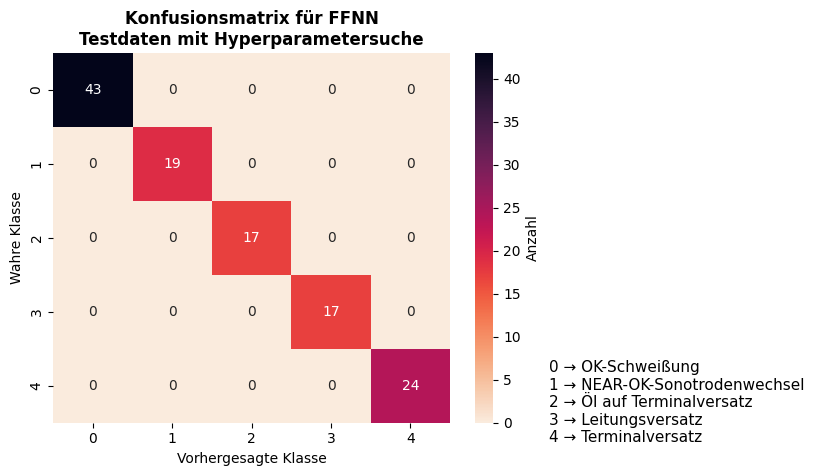

In [14]:
helper.plot_confusion(label_test, pred_test, 'FFNN\nTestdaten mit Hyperparametersuche')

<b><font color='lightgreen'><h3> XGBoost für Regression (Hyperparametersuche - Random Search)

In [15]:
# Hyperparameter-Suche für XGBoost mit RandomizedSearchCV
param_dist = {
    'n_estimators':     randint( 3, 50),    # Anzahl der Bäume
    'max_depth':        randint( 2, 20),    # Tiefe der Bäume 
    'learning_rate':    np.logspace(-2, 1), # Lernrate 
    'subsample':        uniform(0.6, 0.4),  # Anteil der Daten, die für jeden Baum verwendet werden
    # 'colsample_bytree': uniform(0.6, 0.4)   # Anteil der Features pro Baum 
}

# xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) 

random_search = model_selection.RandomizedSearchCV(
    # xgb, 
    ensemble.GradientBoostingRegressor(), 
    param_distributions=param_dist, 
    n_iter=80,  
    cv=3, 
    scoring='r2', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
random_search.fit(X_train_scaled, festigkeit_train)

# Bestes Modell ausgeben
best_xgb = random_search.best_estimator_
best_params = {k: float(v) for k, v in random_search.best_params_.items()}
print("\n Beste Hyperparameter:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Vorhersagen mit dem besten Modell
pred_train = best_xgb.predict(X_train_scaled)
pred_test  = best_xgb.predict(X_test_scaled)

# Modellbewertung
helper.get_metric_table_regr(festigkeit_train, pred_train, festigkeit_test, pred_test, SCALE)

Fitting 3 folds for each of 80 candidates, totalling 240 fits

 Beste Hyperparameter:
learning_rate: 0.12648552168552957
max_depth: 3.0
n_estimators: 46.0
subsample: 0.7791132658292367


,Train,Test
Metric,,
MSE,7566.96,17850.75
RMSE,86.99,133.61
MAE,65.92,86.32
R²,0.99,0.98


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

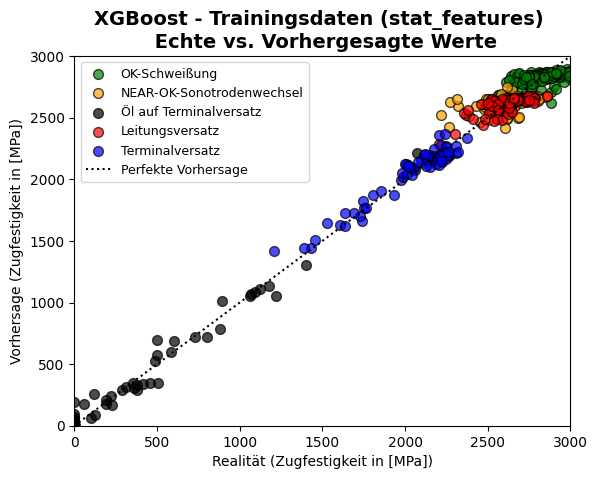

In [16]:
if pca == True:
    helper.plot_pred(pred_train, festigkeit_train, label_train, 'XGBoost mit PCA - Trainingsdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)
else:
    helper.plot_pred(pred_train, festigkeit_train, label_train, 'XGBoost - Trainingsdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)

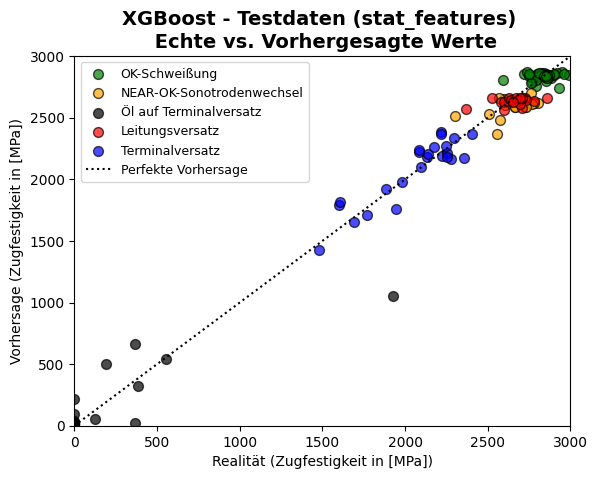

In [17]:
if pca == True:
    helper.plot_pred(pred_test, festigkeit_test, label_test, 'XGBoost mit PCA - Testdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)
else:
    helper.plot_pred(pred_test, festigkeit_test, label_test, 'XGBoost - Testdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)